# Sample Inspector (Part II)



This notebook compares BL books to the genre annotations. We'd like to know if the annotated sample deviates from the digital collection and look at aspects that _should_ remains stable across both datasets.

In [ ]:
%matplotlib inline
import json
import pandas as pd
from collections import Counter

In [ ]:
# in case pandas refuses to open the Excel spreadsheet uncomment this line below
#!pip3 install openpyxl==3.0.0

First, we load the metadata of the BL books collection.

In [ ]:
metadata_blb = pd.read_csv(
    "https://bl.iro.bl.uk/downloads/e1be1324-8b1a-4712-96a7-783ac209ddef?locale=en",
    dtype={"BL record ID": "string"},
    parse_dates=False,
)
metadata_blb.head(3)

,BL record ID,Type of resource,Name,Dates associated with name,Type of name,Role,All names,Title,Variant titles,Series title,Number within series,Country of publication,Place of publication,Publisher,Date of publication,Edition,Physical description,Dewey classification,BL shelfmark,Topics,Genre,Languages,Notes,BL record ID for physical resource
0,014602826,Monograph,"Yearsley, Ann",1753-1806,person,NaN,"More, Hannah, 1745-1833 [person] ; Yearsley, A...",Poems on several occasions [With a prefatory l...,NaN,NaN,NaN,England,London,NaN,1786,Fourth edition MANUSCRIPT note,NaN,NaN,Digital Store 11644.d.32,NaN,NaN,English,NaN,3996603
1,014602830,Monograph,"A, T.",NaN,person,NaN,"Oldham, John, 1653-1683 [person] ; A, T. [person]",A Satyr against Vertue. (A poem: supposed to b...,NaN,NaN,NaN,England,London,NaN,1679,NaN,15 pages (4°),NaN,Digital Store 11602.ee.10. (2.),NaN,NaN,English,NaN,1143
2,014602831,Monograph,NaN,NaN,NaN,NaN,NaN,"The Aeronaut, a poem; founded almost entirely,...",NaN,NaN,NaN,Ireland,Dublin,Richard Milliken,1816,NaN,17 pages (8°),NaN,Digital Store 992.i.12. (3.),Dublin (Ireland),NaN,English,NaN,22782


A simple test for comparing the sample to the BL Books metadata is computing the probabilities of the title's first character. This distribution should look similar for both datasets. Below we create a function `first_alpha_char` that returns the first character of a string. If none could be found, it returns a hashtag.

In [ ]:
def first_alpha_char(x):
    """returns the first lowercased alphatical character of a string"""
    try:
        x = x[0].lower()
        x = "".join([c for c in x if c.isalpha()])
        return x[0]
    except:
        return "#"

With `.apply()` we can extract to first character from the `title` column.

In [ ]:
metadata_blb["first_alpha_char"] = metadata_blb.Title.apply(first_alpha_char)

Next, we use `Counter()` to count all elements in the `first_alpha_char` column and turn the counts into probabilities.

In [ ]:
char_count = Counter(
    metadata_blb[metadata_blb["first_alpha_char"] != None].first_alpha_char
)
char_probs = {k: v / sum(char_count.values()) for k, v in char_count.items()}

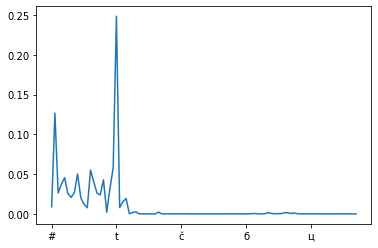

In [ ]:
pd.Series(char_probs, index=sorted(char_probs.keys())).plot()

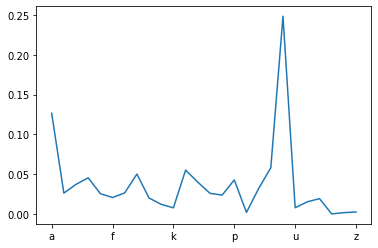

In [ ]:
pd.Series(char_probs, index=sorted(char_probs.keys()))["a":"z"].plot()

Next, we apply the same procedure to the annotated sample. We'll start by loading the annotated sample.

In [ ]:
annotations = pd.read_csv(
    "https://bl.iro.bl.uk/downloads/36c7cd20-c8a7-4495-acbe-469b9132c6b1?locale=en",
    dtype={"BL record ID": str},
)
annotations.head(1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,BL record ID,Type of resource,Name,Dates associated with name,Type of name,Role,All names,Title,Variant titles,Series title,Number within series,Country of publication,Place of publication,Publisher,Date of publication,Edition,Physical description,Dewey classification,BL shelfmark,Topics,Genre,Languages,Notes,BL record ID for physical resource,classification_id,user_id,created_at,subject_ids,annotator_date_pub,annotator_normalised_date_pub,annotator_edition_statement,annotator_genre,annotator_FAST_genre_terms,annotator_FAST_subject_terms,annotator_comments,annotator_main_language,annotator_other_languages_summaries,annotator_summaries_language,annotator_translation,annotator_original_language,annotator_publisher,annotator_place_pub,annotator_country,annotator_title,Link to digitised book,annotated
0,014602826,Monograph,"Yearsley, Ann",1753-1806,person,NaN,"More, Hannah, 1745-1833 [person] ; Yearsley, A...",Poems on several occasions [With a prefatory l...,NaN,NaN,NaN,England,London,NaN,1786,Fourth edition MANUSCRIPT note,NaN,NaN,Digital Store 11644.d.32,NaN,NaN,English,NaN,3996603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


This dataset includes both annotated data and non-annotated data. Since we only want the annotated data, we can filter these out using the `annotated` column which contains a flag to indicate if the data has been annotated. 

In [ ]:
annotations = annotations[annotations["annotated"] == True]

Because of the way in which the annotations were collected we have some duplicates. There are different ways in which we can deal with these duplicates but here we will just drop the duplicates for the `Title` column. 

In [ ]:
annotations = annotations.drop_duplicates(subset="Title")

In [ ]:
annotations["first_alpha_char"] = annotations.Title.apply(first_alpha_char)

In [ ]:
char_count_anno = Counter(
    annotations[annotations["first_alpha_char"] != None].first_alpha_char
)
char_probs_anno = {
    k: v / sum(char_count_anno.values()) for k, v in char_count_anno.items()
}

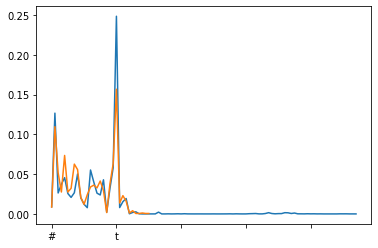

In [ ]:
pd.Series(char_probs, index=sorted(char_probs.keys())).plot()
pd.Series(char_probs_anno, index=sorted(char_probs_anno.keys())).plot()

In [ ]:
annotations["annotator_main_language"].unique()

array([nan, 'lat\nger', 'gmh\nlat\nger', 'ger', 'ger\ngmh\nlat',
       'ger\nfre', 'eng', 'lat\ngmh\nger', 'ger\neng', 'ger\nlat',
       'lat\nfre', 'dut\nfre\nspa', 'fre\nger', 'ger\nfrs\nlat',
       'ger\ngmh', 'lat\ndut\nfrm\nfre', 'ger\nspa', 'eng\nfre'],
      dtype=object)

In [ ]:
annotations["english"] = annotations["annotator_main_language"].apply(
    lambda x: str(x).lower().startswith("eng")
)

Lastly, we can compare the distribution over time to see if the sample is biased towards are certain period.

In [ ]:
metadata_blb = metadata_blb[metadata_blb["Date of publication"].notna()].copy(deep=True)

In [ ]:
metadata_blb["date"] = metadata_blb["Date of publication"].str.split("-").str[0]

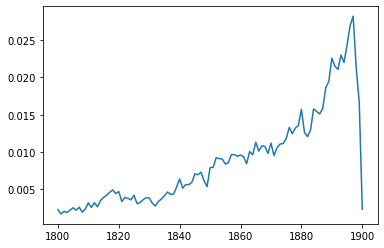

In [ ]:
year_counts = Counter(metadata_blb["date"].values)
year_probs = {k: v / sum(year_counts.values()) for k, v in year_counts.items()}
pd.Series(year_probs, index=sorted(year_probs.keys()))["1800":"1900"].plot()

In [ ]:
year_counts_anno = Counter(annotations["annotator_normalised_date_pub"].values)
year_probs_anno = {
    k: v / sum(year_counts_anno.values()) for k, v in year_counts_anno.items()
}

Below, we made a small function to manipulate the date of publication field by extracting the year (if available) and returning it as an integer.

In [ ]:
def get_int(x):
    """return year is integer"""
    try:
        return int(x)
    except:
        pass
    try:
        return int(x.split("-")[0])
    except:
        False


year_probs_anno = {str(k): v for k, v in year_probs_anno.items() if get_int(k)}

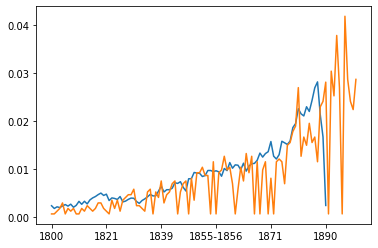

In [ ]:
pd.Series(year_probs, index=sorted(year_probs.keys()))["1800":"1900"].plot()
pd.Series(year_probs_anno, index=sorted(year_probs_anno.keys()))["1800":"1900"].plot()

## Fin.